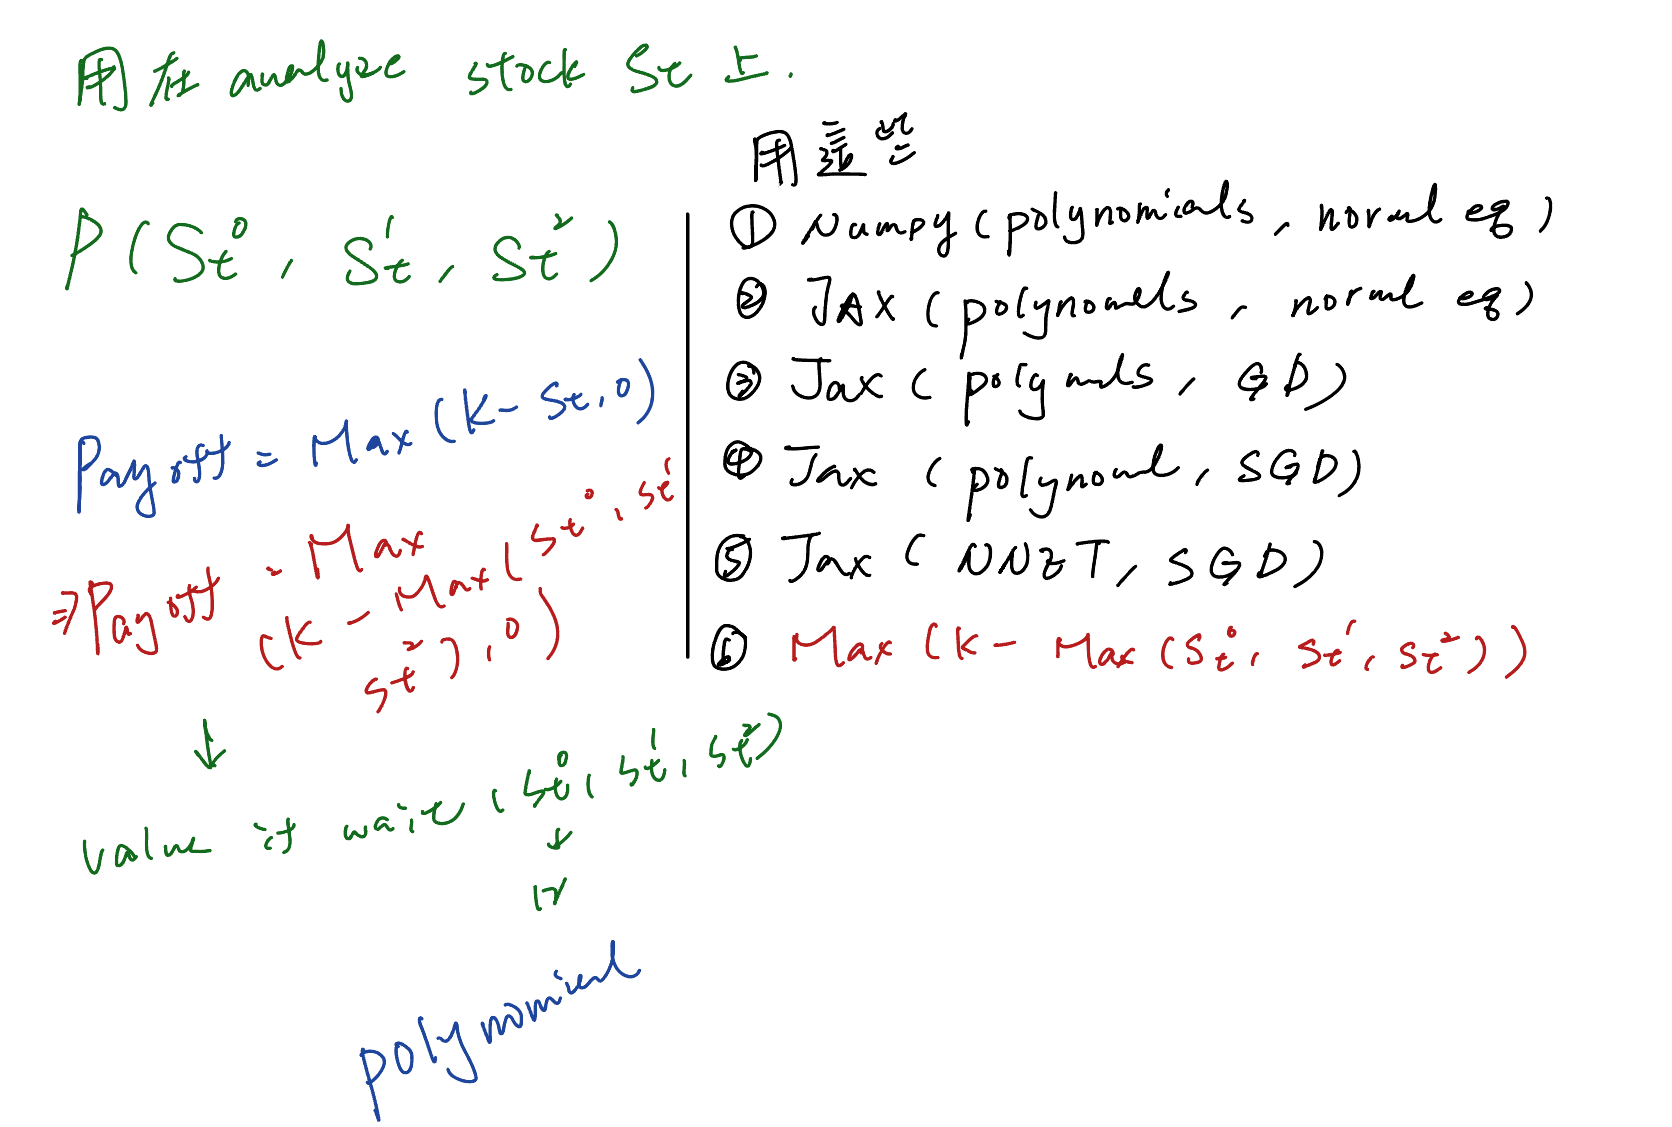

# Numpy (Polynomial, Normal Equation)

In [23]:
import numpy as np

Spot = 36   # stock price
σ = 0.2     # stock volatility
K = 40      # strike price
r = 0.06    # risk free rate
n = 100000  # Number of simualted paths
m = 50      # number of exercise dates
T = 1       # maturity
order = 12   # Polynmial order
Δt = T / m  # interval between two exercise dates

# Construct polynomial features of order up to k using the
# recursive formulation
def chebyshev_basis(x, k):
    B = [np.ones(len(x)), x]
    for n in range(2, k):
        Bn = 2 * x * B[n - 1] - B[n - 2]
        B.append(Bn)

    return np.column_stack(B)


# scales x to be in the interval(-1, 1)
def scale(x):
    xmin = x.min()
    xmax = x.max()
    a = 2 / (xmax - xmin)
    b = 1 - a * xmax
    return a * x + b


# simulates one step of the stock price evolution
def step(S):
    dB = np.sqrt(Δt) * np.random.normal(size=S.size)
    S_tp1 = S + r * S * Δt + σ * S * dB
    return S_tp1



def payoff_put(S):
    return np.maximum(K - S, 0.)


# LSMC algorithm
def compute_price():
    np.random.seed(0)
    S0 = Spot * np.ones(n)
    S = [S0]

    for t in range(m):
        S_tp1 = step(S[t])
        S.append(S_tp1)

    discount = np.exp(-r * Δt)

    # Very last date
    value_if_exercise = payoff_put(S[-1])
    discounted_future_cashflows = value_if_exercise * discount

    # Proceed recursively
    for i in range(m - 1):
        X = chebyshev_basis(scale(S[-2 - i]), order)
        Y = discounted_future_cashflows

        Θ = np.linalg.lstsq(X, discounted_future_cashflows)[0]
        value_if_wait = X @ Θ
        value_if_exercise = payoff_put(S[-2 - i])
        exercise = value_if_exercise >= value_if_wait
        discounted_future_cashflows = discount * np.where(
            exercise,
            value_if_exercise,
            discounted_future_cashflows)

    return discounted_future_cashflows.mean()


print(compute_price())
# test = compute_price(order, Spot, σ, K, r)

<ipython-input-23-5ccda1771052>:66: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Θ = np.linalg.lstsq(X, discounted_future_cashflows)[0]


4.4634476148734405


# JAX (Polynomial, Normal Equation)

In [37]:
# JAX version
import jax.numpy as jnp
import jax

Spot = 36   # stock price
σ = 0.2     # stock volatility
K = 40      # strike price
r = 0.06    # risk free rate
n = 100000  # Number of simualted paths
m = 50      # number of exercise dates
T = 1       # maturity
order = 12   # Polynmial order
Δt = T / m  # interval between two exercise dates


# Construct polynomial features of order up to k using the
# recursive formulation
def chebyshev_basis(x, k):

    def Bn(carry, xs):
        b1, b2 = carry
        Bn = 2 * x * b2 - b1
        carry = b2, Bn
        return carry, Bn

    init = jnp.ones(len(x)), x
    carry, B = jax.lax.scan(Bn, init, xs=None, length=k-2)

    B = jnp.insert(B, 0, values=x, axis=0)
    B = jnp.insert(B, 0, values=jnp.ones(len(x)), axis=0)

    return B.T


# scales x to be in the interval(-1, 1)
def scale(x):
    xmin = x.min()
    xmax = x.max()
    a = 2 / (xmax - xmin)
    b = 1 - a * xmax
    return a * x + b


# simulates one step of the stock price evolution
def step(S, x):
    dB = jnp.sqrt(Δt) * x
    S_tp1 = S + r * S * Δt + σ * S * dB
    return S_tp1, S_tp1


def payoff_put(S):
    return jnp.maximum(K - S, 0.)


# LSMC algorithm
@jax.jit
def compute_price():
    rng = jax.random.PRNGKey(0)
    S0 = Spot * jnp.ones(n)
    xs = jax.random.normal(rng, shape=(m, S0.size))
    carry, S = jax.lax.scan(step, S0, xs)
    S = jnp.insert(S, 0, values=S0, axis=0)

    discount = jnp.exp(-r * Δt)

    # Very last date
    value_if_exercise = payoff_put(S[-1])
    discounted_future_cashflows = value_if_exercise * discount

    def recur(Y, S):
        X = chebyshev_basis(scale(S), order)
        Θ = jnp.linalg.solve(X.T @ X, X.T @ Y)
        value_if_wait = X @ Θ
        value_if_exercise = payoff_put(S)
        exercise = value_if_exercise >= value_if_wait
        Y = discount * jnp.where(
            exercise,
            value_if_exercise,
            Y)
        return Y, Y

    Y = discounted_future_cashflows
    discounted_future_cashflows, ys = jax.lax.scan(
        recur, Y, S[:-1], reverse=True)

    return discounted_future_cashflows.mean()


print(compute_price())

4.4773197


# JAX (Polynomial, Gradient Descent)

Steps:
1. Initialize the Θ (99 x 12)
2. Θ = Θ - learning_rate x gradient 

In [26]:
from time import sleep
import jax.numpy as jnp
import jax
import optax

Spot = 36   # stock price
σ = 0.2     # stock volatility
K = 40      # strike price
r = 0.06    # risk free rate
n = 512  # Number of simualted paths
m = 100      # number of exercise dates （要simulate多少天）
T = 1       # maturity
order = 12   # Polynmial order (次方數)
Δt = T / m  # interval between two exercise dates

#Optimizer Setting
optimizer = optax.adam
learning_rate = 1e-3

def chebyshev_basis(x, k):
    B = [jnp.ones(len(x)), x]
    for n in range(2, k):
        Bn = 2 * x * B[n - 1] - B[n - 2]
        B.append(Bn)

    return jnp.column_stack(B)


# scales x to be in the interval(-1, 1)
def scale(x):
    xmin = 10.
    xmax = 80.
    a = 2 / (xmax - xmin)
    b = 1 - a * xmax
    return a * x + b

# simulates one step of the stock price evolution
def step(S, rng):
    ϵ = jax.random.normal(rng, shape = S.shape)
    dB = jnp.sqrt(Δt) * ϵ
    S = S + r * S * Δt + σ * S * dB
    return S, S


def payoff_put(S):
    return jnp.maximum(K - S, 0.)

In [27]:
# The process visualization
def process_visualization(iteration, total):
    print('\r' + '[Progress]:[%s%s]%.2f%%;' % (
    '███' * int((iteration+1)*20/total), '   ' *
                (20-int((iteration+1)*20/total)),
    float((iteration+1)/total*100)), end='')
    sleep(0.01)

In [28]:
#Initialize the Θ and optimizer state
Θ = jnp.zeros((m - 1, order))
opt_state = optimizer(learning_rate).init(Θ)

In [29]:
# LSMC algorithm and return MSE in order to put into Loss function
#@jax.jit
def compute_price(Θ):
    S = Spot * jnp.ones(n) #(100, 100000) = (m, n)
    rng = jax.random.PRNGKey(0)
    rng_vector = jax.random.split(rng, m)
    _, S = jax.lax.scan(step, S, rng_vector)

    discount = jnp.exp(-r * Δt)

    # Very last date
    # From the last Stock price to get the initial price
    value_if_exercise = payoff_put(S[-1])
    discounted_future_cashflows = value_if_exercise * discount

    # Proceed recursively and loop it by jax.lax.scan
    #inputs = jnp.flip(S[:-1], 0), Θ

    def core(state, inputs):
        discounted_future_cashflows = state
        Si, Θi = inputs
        X = chebyshev_basis(scale(Si), order)
        Y = discounted_future_cashflows
        
        value_if_wait = X @ Θi
        
        #Θi = jnp.linalg.lstsq(X, discounted_future_cashflows)[0]
        #setting up the mse, and minimizing it 
        
        MSE = jnp.mean((value_if_wait - discounted_future_cashflows)**2)
              
        value_if_exercise = payoff_put(Si)
        exercise = value_if_exercise >= value_if_wait
        discounted_future_cashflows = discount * jnp.where(
            exercise,
            value_if_exercise,
            discounted_future_cashflows)
        return discounted_future_cashflows, MSE
    
    S = jnp.flip(S, 0)[1:]
    inputs = S, Θ
    
    discounted_future_cashflows, MSE = jax.lax.scan(core, discounted_future_cashflows, inputs)
    return discounted_future_cashflows.mean(), MSE

print(compute_price(Θ)[0])

3.944481


We use compute_price() to generate MSE, and add put them into Loss funtion and do the gradient descent in update()

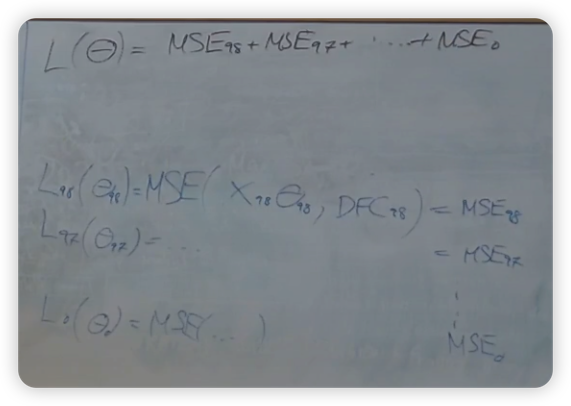

In [30]:
# Gradient descent part
# Θ = Θ - learning_rate x gradient


def L(Θ):
    _, MSE = compute_price(Θ)
    return MSE.sum()  # will be on exam

@jax.jit
def update(Θ, opt_state):

    # Loss function of Gradient Descent

    gradient = jax.grad(L)(Θ)
    updates, opt_state = optimizer(learning_rate).update(gradient, opt_state)
    Θ = optax.apply_updates(Θ, updates)
    return Θ, opt_state


def evaluate(Θ):
    p, _ = compute_price(Θ)
    return p

In [ ]:
for iteration in range(1000):
    process_visualization(iteration, 1000)
    #print(Θ[0], L(Θ), compute_price(Θ)[0])
    Θ, opt_state = update(Θ, opt_state)
print("\n")
print(compute_price(Θ)[0])

[Progress]:[███                                                         ]7.80%;

# JAX (Polynomial, Stochastic Gradient Descent)

In [ ]:
import jax.numpy as jnp
import jax
import optax
from time import sleep

Spot = 36   # stock price
σ = 0.2     # stock volatility
K = 40      # strike price
r = 0.06    # risk free rate
n = 1000  # Number of simualted paths
batch_size = 512

m = 100      # number of exercise dates
T = 1       # maturity
order = 5   # Polynmial order
Δt = T / m  # interval between two exercise dates

# simulates one step of the stock price evolution
def chebyshev_basis(x, k):
    B = [jnp.ones(len(x)), x]
    for n in range(2, k):
        Bn = 2 * x * B[n - 1] - B[n - 2]
        B.append(Bn)

    return jnp.column_stack(B)


# scales x to be in the interval(-1, 1)
def scale(x):
    xmin = 10.
    xmax = 80.
    a = 2 / (xmax - xmin)
    b = 1 - a * xmax
    return a * x + b

def step(S, rng):
    ϵ = jax.random.normal(rng, shape=S.shape)
    dB = jnp.sqrt(Δt) * ϵ
    S = S + r * S * Δt + σ * S * dB
    return S, S


def payoff_put(S):
    return jnp.maximum(K - S, 0.)


def model(Θi, Si):
    X = chebyshev_basis(scale(Si), order)
    vale_if_wait = X @ Θi
    return vale_if_wait


def mse(prediction, label):
    return jnp.mean((prediction - label)**2)

In [46]:
# Initialization
Θ = jnp.zeros((m - 1, order))
opt_state = optimizer(learning_rate).init(Θ)
rng = jax.random.PRNGKey(0)

optimizer = optax.adam
learning_rate = 1e-4

In [47]:
# LSMC algorithm
# @jax.jit
def compute_price(Θ, n, rng):

    S = Spot * jnp.ones(n)

    state = S

    # reshaping for input
    rng_vector = jax.random.split(rng, m)
    _, S = jax.lax.scan(step, state, rng_vector)

    discount = jnp.exp(-r * Δt)

    # Very last date
    # From the last Stock price to get the initial price
    value_if_exercise = payoff_put(S[-1])
    discounted_future_cashflows = value_if_exercise * discount
    state = discounted_future_cashflows

    # Proceed recursively and loop it by jax.lax.scan
    inputs = jnp.flip(S[:-1], 0), Θ

    def core(state, inputs):
        discounted_future_cashflows = state
        Si, Θi = inputs
        value_if_wait = model(Θi, Si)  # Not using Chevbyshev anymore

        MSE = mse(value_if_wait, discounted_future_cashflows)

        value_if_exercise = payoff_put(Si)
        exercise = value_if_exercise >= value_if_wait
        discounted_future_cashflows = discount * jnp.where(
            exercise,
            value_if_exercise,
            discounted_future_cashflows)
        return discounted_future_cashflows, MSE

    discounted_future_cashflows, MSE = jax.lax.scan(core, state, inputs)
    return discounted_future_cashflows.mean(), MSE


print(compute_price(Θ, n, rng)[0])

3.9780037


In [48]:
# The process visualization
def process_visualization(iteration, total):
    print('\r' + '[Progress]:[%s%s]%.2f%%;' % (
    '███' * int((iteration+1)*20/total), '   ' *
                (20-int((iteration+1)*20/total)),
    float((iteration+1)/total*100)), end='')
    sleep(0.01)

In [49]:
# Loss function of Gradient Descent
def L(Θ, rng):
    price, MSE = compute_price(Θ, batch_size, rng)
    return MSE.sum()


@jax.jit
def update(Θ, opt_state, rng):
    rng, _ = jax.random.split(rng)  # for not reusing the same key as seed
    gradient = jax.grad(L)(Θ, rng)
    updates, opt_state = optimizer(learning_rate).update(gradient, opt_state)
    Θ = optax.apply_updates(Θ, updates)
    return Θ, opt_state, rng


def evaluate(Θ):
    rng = jax.random.PRNGKey(0)
    p, _ = compute_price(Θ, n, rng)
    return p

In [50]:
#Descent Iteration
total = 1000
rng = jax.random.PRNGKey(0)
for iteration in range(total):
    process_visualization(iteration, total)
    #print(evaluate(Θ,n, rng))
    Θ, opt_state, rng = update(Θ, opt_state, rng)
print("\n")
print(compute_price(Θ,n, rng)[0])

[Progress]:[████████████████████████████████████████████████████████████]100.00%;

3.9739401


# JAX (Neural Network, Stochastic Gradient Descent)

Neutral Network is Trained in Gradient Descent

In [21]:
import jax.numpy as jnp
import jax
import optax
import haiku as hk
from time import sleep

Spot = 36   # stock price
σ = 0.2     # stock volatility
K = 40      # strike price
r = 0.06    # risk free rate
n = 100000  # Number of simualted paths
batch_size = 512

m = 100      # number of exercise dates
T = 1       # maturity
order = 12  # Polynmial order
Δt = T / m  # interval between two exercise dates

# simulates one step of the stock price evolution
def chebyshev_basis(x, k):
    B = [np.ones(len(x)), x]
    for n in range(2, k):
        Bn = 2 * x * B[n - 1] - B[n - 2]
        B.append(Bn)

    return np.column_stack(B)

# scales x to be in the interval(-1, 1)
def scale(x):
    xmin = x.min()
    xmax = x.max()
    a = 2 / (xmax - xmin)
    b = 1 - a * xmax
    return a * x + b


def step(S, rng):
    ϵ = jax.random.normal(rng, shape=S.shape)
    dB = jnp.sqrt(Δt) * ϵ
    S = S + r * S * Δt + σ * S * dB
    return S, S


def payoff_put(S):
    return jnp.maximum(K - S, 0.)


def model(Θi, Si):
    X = chebyshev_basis(scale(Si), order)
    vale_if_wait = X @ Θi
    return vale_if_wait


def mse(prediction, label):
    return jnp.mean((prediction - label)**2)

In [25]:
#Neural Metwork Modelling
def model(Si):
    out = (jnp.column_stack([Si])-37)/5.
    
    out = hk.Linear(32)(out)
    out = jax.nn.relu(out)
    
    out = hk.Linear(32)(out)
    out = jax.nn.relu(out)
    
    out = hk.Linear(1)(out)

    return jnp.squeeze(out)

init, model = hk.without_apply_rng(hk.transform(model)) 


In [26]:
#Initialization
rng = jax.random.PRNGKey(0)
Θ = init(rng, jnp.array(1.)) #[99x12] #It is dictionary so it cannot be use as jnp. 

def stack(Θ):
    return jnp.stack([Θ] * (m-1))
Θ = jax.tree_map(stack, Θ)


optimizer = optax.adam
learning_rate = 1e-4
opt_state = optimizer(learning_rate).init(Θ)

In [24]:
# LSMC algorithm
#@jax.jit
def compute_price(Θ,n, rng):
    
    S = Spot * jnp.ones(n)

    state = S

    # reshaping for input
    rng_vector = jax.random.split(rng, m)
    _, S = jax.lax.scan(step, state, rng_vector)

    discount = jnp.exp(-r * Δt)

    # Very last date
    # From the last Stock price to get the initial price
    value_if_exercise = payoff_put(S[-1])
    discounted_future_cashflows = value_if_exercise * discount
    state = discounted_future_cashflows

    # Proceed recursively and loop it by jax.lax.scan
    inputs = jnp.flip(S[:-1], 0), Θ

    def core(state, inputs):
        discounted_future_cashflows = state
        Si, Θi = inputs
        value_if_wait = model(Θi, Si)#Not using Chevbyshev anymore
        
        MSE = mse(value_if_wait, discounted_future_cashflows)
              
        value_if_exercise = payoff_put(Si)
        exercise = value_if_exercise >= value_if_wait
        discounted_future_cashflows = discount * jnp.where(
            exercise,
            value_if_exercise,
            discounted_future_cashflows)
        return discounted_future_cashflows, MSE
        
    discounted_future_cashflows, MSE = jax.lax.scan(core, state, inputs)
    return discounted_future_cashflows.mean(), MSE


print(compute_price(Θ,n, rng)[0])

NameError: name 'shape' is not defined

In [18]:
# The process visualization
def process_visualization(iteration, total):
    print('\r' + '[Progress]:[%s%s]%.2f%%;' % (
    '███' * int((iteration+1)*20/total), '   ' *
                (20-int((iteration+1)*20/total)),
    float((iteration+1)/total*100)), end='')
    sleep(0.01)


In [19]:
#Loss function of Gradient Descent
def L(Θ,rng):
    price, MSE = compute_price(Θ, batch_size, rng)
    return MSE.sum()

@jax.jit
def update(Θ, opt_state, rng):
    rng, _ = jax.random.split(rng) #for not reusing the same key as seed
    gradient = jax.grad(L)(Θ, rng)
    updates, opt_state = optimizer(learning_rate).update(gradient, opt_state)
    Θ = optax.apply_updates(Θ, updates)
    return Θ, opt_state, rng

def evaluate(Θ):    
    rng = jax.random.PRNGKey(0)
    p, _ = compute_price(Θ,n,rng)
    return p

In [20]:
total = 10000
rng = jax.random.PRNGKey(0)
for iteration in range(total):
    process_visualization(iteration, total)
    #print(evaluate(Θ,n, rng))
    Θ, opt_state, rng = update(Θ, opt_state, rng)
print("\n")
print(compute_price(Θ,n, rng)[0])

[Progress]:[                                                            ]0.01%;Traced<ShapedArray(float32[512,1])>with<DynamicJaxprTrace(level=3/1)>
[Progress]:[██████████████████                                          ]34.03%;

KeyboardInterrupt: 